# Emergenza COVID-19 italiana

### Importazione librerie e definizioni essenziali

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

show_covm = False # Mostra le matrici di covarianza nei fit

def expf(t, A, k):
    return A*np.exp(k*t)

def gompertz(t,a,b,c):
    '''Gompertz function (generalized logistic model)'''
    return a*np.exp(-b*np.exp(-c*t))

def dgompertz(t,a,b,c):
    '''Time derivative of gompertz(t,a,b,c)'''
    return a*b*c*np.exp(-b*np.exp(-c*t) - c*t)

def d2gompertz(t,a,b,c):
    ''' Time 2-derivative of gompertz(t,a,b,c)'''
    return a*b*np.exp(-b*np.exp(-c*t) - c*t) + a*b*c*np.exp(-b*np.exp(-c*t) - c*t) * (-t + b *np.exp(-c*t)*t)

### Importazione dati
Fonte: [GitHub Protezione Civile](https://github.com/pcm-dpc/COVID-19)

In [2]:
italia = pd.read_json("http://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json")
province = pd.read_json("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-province.json")
regioni = pd.read_json("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json")

print('Dati nazionali aggiornati al', italia.tail(1).iloc[0]['data'])
print('Dati regionali aggiornati al', regioni.tail(1).iloc[0]['data'])
print('Dati provinciali aggiornati al', province.tail(1).iloc[0]['data'])

Dati nazionali aggiornati al 2020-04-18T17:00:00
Dati regionali aggiornati al 2020-04-18T17:00:00
Dati provinciali aggiornati al 2020-04-18T17:00:00


In [3]:
#print(f'Dati nazionali: {italia.columns}')
#print(f'Dati regionali: {regioni.columns}')
#print(f'Dati provinciali: {province.columns}')

## Andamento nazionale

In [4]:
# Scegliere colonna da analizzare (elencati nella cella precedente ^)
it_casi = italia['totale_casi']

tau = 7         # scala temporale di risposta del sistema (~1 settimana)
t_lockdown = 15 # giorno dell'entrata in vigore del DPCM 

t = np.linspace(0, it_casi.size - 1, it_casi.size) - t_lockdown

masks = [(t < 0)]



for i in range(0, it_casi.size // tau):
    test = np.logical_and(t >= (i*tau), t < ((i+1)*tau))
    if test.any():
        masks.append(test)
        
t = t + t_lockdown

initp = np.array([1,0.2])

exp_popts = []
exp_pcovs = []

for i, mask in enumerate(masks):
    popt, pcov = curve_fit(expf, t[mask], it_casi[mask], initp)
    exp_popts.append(popt)
    exp_pcovs.append(pcov)


for i, (popt, pcov) in enumerate(zip(exp_popts, exp_pcovs)):
    print(f"Fit numerico all'esponenziale - periodo {i}")
    dpopt = np.sqrt(np.diagonal(pcov))
    print(f"\tAmpiezza: {popt[0]} +- {dpopt[0]}")
    print(f"\tEsponente: {popt[1]} +- {dpopt[1]}")
    if show_covm:
        print(f"\tMatrice di covarianza: \t {pcov} \n")
        
# Gompertz fit
initp = np.array([100000,1,1])
gom_popt, gom_pcov = curve_fit(gompertz, t, it_casi, initp)

print("Fit numerico alla funzione di Gompertz")
gom_dpopt = np.sqrt(np.diagonal(gom_pcov))
print(f"\ta: {gom_popt[0]} +- {gom_dpopt[0]}")
print(f"\tb: {gom_popt[1]} +- {gom_dpopt[1]}")
print(f"\tc: {gom_popt[2]} +- {gom_dpopt[2]}")


Fit numerico all'esponenziale - periodo 0
	Ampiezza: 398.7969960743963 +- 19.611305717557627
	Esponente: 0.22434096131831022 +- 0.003953367367997255
Fit numerico all'esponenziale - periodo 1
	Ampiezza: 931.5898884258855 +- 101.49705551432436
	Esponente: 0.16306686464057682 +- 0.00565013414642608
Fit numerico all'esponenziale - periodo 2
	Ampiezza: 2463.9071084099946 +- 347.5453113396471
	Esponente: 0.11721567532467578 +- 0.005432499112777178
Fit numerico all'esponenziale - periodo 3
	Ampiezza: 10889.930602207776 +- 1062.7943669367073
	Esponente: 0.06434873407206702 +- 0.0029967371527390404
Fit numerico all'esponenziale - periodo 4
	Ampiezza: 27520.772072518965 +- 1261.8518884206462
	Esponente: 0.03761099483008986 +- 0.0011652178832448267
Fit numerico all'esponenziale - periodo 5
	Ampiezza: 41454.20995433909 +- 1226.953941338049
	Esponente: 0.027598248063732598 +- 0.0006397710268622805
Fit numerico all'esponenziale - periodo 6
	Ampiezza: 59013.68230213304 +- 1566.0675172910608
	Esponent

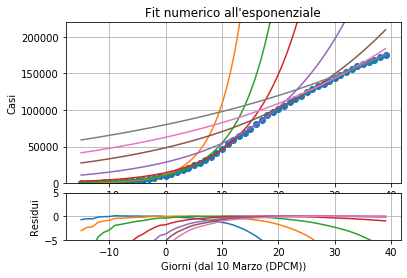

In [5]:
t = np.linspace(0, it_casi.size - 1, it_casi.size) - t_lockdown
tt = np.linspace(0, it_casi.size-1, it_casi.size*100) - t_lockdown

# Dati e fit
plt.subplot2grid((4,1),(0,0), rowspan = 3)
plt.title("Fit numerico all'esponenziale")
plt.tick_params(labelbottom='off')
plt.grid()
plt.ylabel('Casi')
plt.ylim(0,it_casi.max() * 1.25)

plt.plot(t,it_casi,marker='o')

for popt in exp_popts:
    plt.plot(tt, expf(tt + t_lockdown, *popt))

# Residui
plt.subplot2grid((4,1),(3,0))
plt.grid()
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Residui')

for popt in exp_popts:
    plt.ylim(-5,5)
    plt.plot(t, (it_casi - expf(t + t_lockdown, *popt))/it_casi)



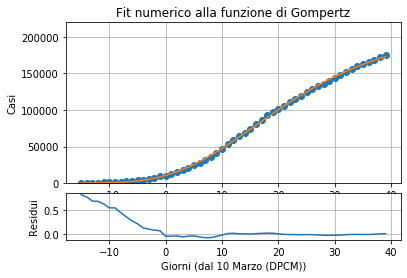

In [6]:
t = np.linspace(0, it_casi.size - 1, it_casi.size) - t_lockdown
tt = np.linspace(0, it_casi.size-1, it_casi.size*100) - t_lockdown

# Dati e fit
plt.subplot2grid((4,1),(0,0), rowspan = 3)
plt.title("Fit numerico alla funzione di Gompertz")
plt.tick_params(labelbottom='off')
plt.grid()
plt.ylabel('Casi')
plt.ylim(0,it_casi.max() * 1.25)

plt.plot(t,it_casi,marker='o')
    
plt.plot(tt, gompertz(tt + t_lockdown, *gom_popt))
# Residui
plt.subplot2grid((4,1),(3,0))
plt.grid()
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Residui')

plt.plot(t, (it_casi - gompertz(t + t_lockdown, *gom_popt))/it_casi)



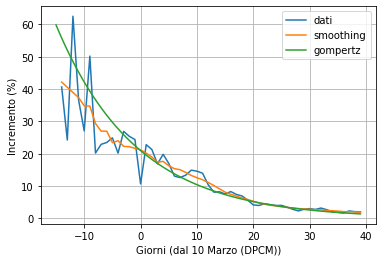

In [7]:
## Incremento percentuale
from scipy.signal import savgol_filter

ratio = (it_casi / np.roll(it_casi,1) - 1) * 100
ratio = ratio[1:]
smoothr = savgol_filter(ratio,7,1)     #magari sostituire con la predizione dei fit
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Incremento (%)')
plt.grid()
plt.plot(t[1:], ratio, label='dati')
plt.plot(t[1:], smoothr, label='smoothing')
plt.plot(tt, 100*dgompertz(tt + t_lockdown, *gom_popt)/gompertz(tt + t_lockdown, *gom_popt), label='gompertz')
plt.legend()

## Andamento regionale

In [8]:
# Scegliere la regione e il campo da analizzare:
regione = 'Lombardia'

reg_data = regioni[regioni.denominazione_regione.eq(regione)]
reg_casi = reg_data['totale_casi']

In [9]:
t = np.linspace(0, reg_casi.size - 1, reg_casi.size)

tau = 7         # scala temporale di risposta del sistema (~1 settimana)
t_lockdown = 15 # giorno dell'entrata in vigore del DPCM 
t = t - t_lockdown

masks = [(t < 0)]

for i in range(0, reg_casi.size // tau):
    test = np.logical_and(t >= (i*tau), t < ((i+1)*tau))
    if test.any():
        masks.append(test)

t = t + t_lockdown

initp = np.array([1,0.2])

exp_popts = []
exp_pcovs = []

for i, mask in enumerate(masks):
    popt, pcov = curve_fit(expf, t[mask], reg_casi[mask], initp)
    exp_popts.append(popt)
    exp_pcovs.append(pcov)

for i, (popt, pcov) in enumerate(zip(exp_popts, exp_pcovs)):
    print(f"Fit numerico all'esponenziale - periodo {i}")
    dpopt = np.sqrt(np.diagonal(pcov))
    print(f"\tAmpiezza: {popt[0]} +- {dpopt[0]}")
    print(f"\tEsponente: {popt[1]} +- {dpopt[1]}")
    if show_covm:
        print(f"\tMatrice di covarianza: \t {pcov} \n")
        
# Gompertz fit
initp = np.array([10000,1,1])
gom_popt, gom_pcov = curve_fit(gompertz, t, reg_casi, initp)

print("Fit numerico alla funzione di Gompertz")
gom_dpopt = np.sqrt(np.diagonal(gom_pcov))
print(f"\ta: {gom_popt[0]} +- {gom_dpopt[0]}")
print(f"\tb: {gom_popt[1]} +- {gom_dpopt[1]}")
print(f"\tc: {gom_popt[2]} +- {gom_dpopt[2]}")


Fit numerico all'esponenziale - periodo 0
	Ampiezza: 233.3183441305178 +- 14.391205221155948
	Esponente: 0.2241689299561512 +- 0.004959165214127695
Fit numerico all'esponenziale - periodo 1
	Ampiezza: 726.3750557090445 +- 106.7403805137138
	Esponente: 0.1444043881294698 +- 0.007666390854979729
Fit numerico all'esponenziale - periodo 2
	Ampiezza: 1909.7992893293874 +- 302.03120494949974
	Esponente: 0.0979251716186042 +- 0.00612262156791705
Fit numerico all'esponenziale - periodo 3
	Ampiezza: 6508.0713039561315 +- 758.3788787650111
	Esponente: 0.05398606342355138 +- 0.003586914943857059
Fit numerico all'esponenziale - periodo 4
	Ampiezza: 14988.576102136514 +- 499.0285287594076
	Esponente: 0.02954413708319527 +- 0.0008474719200561027
Fit numerico all'esponenziale - periodo 5
	Ampiezza: 18465.64770886882 +- 290.12073978899326
	Esponente: 0.024178456965831388 +- 0.00033980772282838994
Fit numerico all'esponenziale - periodo 6
	Ampiezza: 27523.25148432796 +- 922.8131068875308
	Esponente: 0.

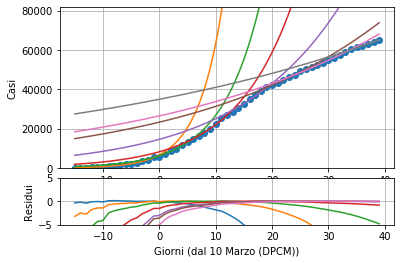

In [10]:
t = np.linspace(0, reg_casi.size - 1, reg_casi.size) - t_lockdown
tt = np.linspace(0, reg_casi.size-1, reg_casi.size*100) - t_lockdown

# Dati e fit
plt.subplot2grid((4,1),(0,0), rowspan = 3)
plt.tick_params(labelbottom='off')
plt.grid()
plt.ylabel('Casi')
plt.ylim(0,reg_casi.max() * 1.25)

plt.plot(t,reg_casi,marker='o')

for popt in exp_popts:
    plt.plot(tt, expf(tt + t_lockdown, *popt))
    
# Residui
plt.subplot2grid((4,1),(3,0))
plt.grid()
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Residui')

for popt in exp_popts:
    plt.ylim(-5,5)
    plt.plot(t, (reg_casi - expf(t + t_lockdown, *popt))/reg_casi)

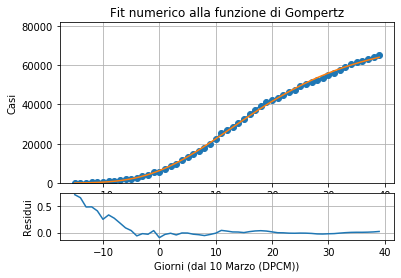

In [11]:
t = np.linspace(0, reg_casi.size - 1, reg_casi.size) - t_lockdown
tt = np.linspace(0, reg_casi.size-1, reg_casi.size*100) - t_lockdown

# Dati e fit
plt.subplot2grid((4,1),(0,0), rowspan = 3)
plt.title("Fit numerico alla funzione di Gompertz")
plt.tick_params(labelbottom='off')
plt.grid()
plt.ylabel('Casi')
plt.ylim(0,reg_casi.max() * 1.25)

plt.plot(t,reg_casi,marker='o')
    
plt.plot(tt, gompertz(tt + t_lockdown, *gom_popt))
# Residui
plt.subplot2grid((4,1),(3,0))
plt.grid()
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Residui')

plt.plot(t, (reg_casi - gompertz(t + t_lockdown, *gom_popt))/reg_casi)

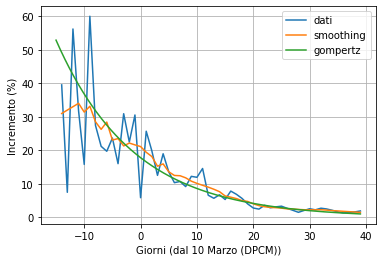

In [12]:
## Incremento percentuale
from scipy.signal import savgol_filter

ratio = (reg_casi / np.roll(reg_casi,1) - 1) * 100
ratio = ratio[1:]
smoothr = savgol_filter(ratio,7,1)     #magari sostituire con la predizione dei fit
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Incremento (%)')
plt.grid()
plt.plot(t[1:], ratio, label='dati')
plt.plot(t[1:], smoothr, label='smoothing')
plt.plot(tt, 100*dgompertz(tt + t_lockdown, *gom_popt)/gompertz(tt + t_lockdown, *gom_popt), label='gompertz')
plt.legend()

## Andamento provinciale

In [13]:
# Scegliere la provincia e il campo da analizzare
provincia = 'RM'

pv_data = province[province.sigla_provincia.eq(provincia)] 
pv_casi = pv_data['totale_casi']

In [14]:
tau = 7         # scala temporale di risposta del sistema (~1 settimana)
t_lockdown = 15 # giorno dell'entrata in vigore del DPCM 
t = np.linspace(0, pv_casi.size - 1, pv_casi.size) - t_lockdown

masks = [(t < 0)]

for i in range(0, pv_casi.size // tau - 1):
    test = np.logical_and(t >= (i*tau), t < ((i+1)*tau))
    if test.any():
        masks.append(test)

t = t + t_lockdown

initp = np.array([1,0.2])

exp_popts = []
exp_pcovs = []

for i, mask in enumerate(masks):
    popt, pcov = curve_fit(expf, t[mask], pv_casi[mask], initp)
    exp_popts.append(popt)
    exp_pcovs.append(pcov)

for i, (popt, pcov) in enumerate(zip(exp_popts, exp_pcovs)):
    print(f"Fit numerico all'esponenziale - periodo {i}")
    dpopt = np.sqrt(np.diagonal(pcov))
    print(f"\tAmpiezza: {popt[0]} +- {dpopt[0]}")
    print(f"\tEsponente: {popt[1]} +- {dpopt[1]}")
    if show_covm:
        print(f"\tMatrice di covarianza: \t {pcov} \n")
        
# Gompertz fit
initp = np.array([10000,1,1])
gom_popt, gom_pcov = curve_fit(gompertz, t, pv_casi, initp)

print("Fit numerico alla funzione di Gompertz")
gom_dpopt = np.sqrt(np.diagonal(gom_pcov))
print(f"\ta: {gom_popt[0]} +- {gom_dpopt[0]}")
print(f"\tb: {gom_popt[1]} +- {gom_dpopt[1]}")
print(f"\tc: {gom_popt[2]} +- {gom_dpopt[2]}")

Fit numerico all'esponenziale - periodo 0
	Ampiezza: 2.530366249104696 +- 0.6839101694885137
	Esponente: 0.26205793102719427 +- 0.021297930278066382
Fit numerico all'esponenziale - periodo 1
	Ampiezza: 2.2687860083212605 +- 0.9794058531208555
	Esponente: 0.2502201813644352 +- 0.021871586644853492
Fit numerico all'esponenziale - periodo 2
	Ampiezza: 21.440405821243683 +- 2.354625105832701
	Esponente: 0.14331042592733712 +- 0.0042016304377344126
Fit numerico all'esponenziale - periodo 3
	Ampiezza: 145.26949480973624 +- 17.93222637233542
	Esponente: 0.07634439398136024 +- 0.0037799133819192325
Fit numerico all'esponenziale - periodo 4
	Ampiezza: 499.7659029613143 +- 44.010631036875616
	Esponente: 0.04111289608969991 +- 0.002236391352506202
Fit numerico all'esponenziale - periodo 5
	Ampiezza: 710.2786535328196 +- 14.519535249501242
	Esponente: 0.032132526304785275 +- 0.00044152242266751537
Fit numerico all'esponenziale - periodo 6
	Ampiezza: 785.9730815199205 +- 26.059183615793067
	Esponen

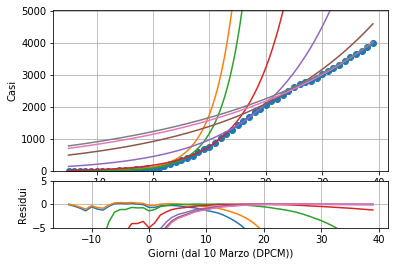

In [15]:
t = np.linspace(0, pv_casi.size - 1, pv_casi.size) - t_lockdown
tt = np.linspace(0, pv_casi.size-1, pv_casi.size*100) - t_lockdown

# Dati e fit
plt.subplot2grid((4,1),(0,0), rowspan = 3)
plt.tick_params(labelbottom='off')
plt.grid()
plt.ylabel('Casi')
plt.ylim(0,pv_casi.max() * 1.25)

plt.plot(t,pv_casi,marker='o')

for popt in exp_popts:
    plt.plot(tt, expf(tt + t_lockdown, *popt))
    
# Residui
plt.subplot2grid((4,1),(3,0))
plt.grid()
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Residui')

for popt in exp_popts:
    plt.ylim(-5,5)
    plt.plot(t, (pv_casi - expf(t + t_lockdown, *popt))/pv_casi)

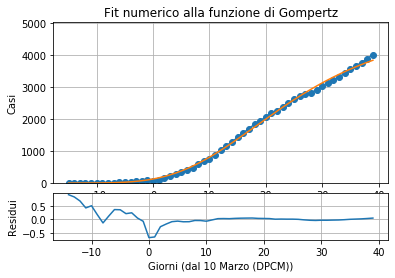

In [16]:
t = np.linspace(0, pv_casi.size - 1, pv_casi.size) - t_lockdown
tt = np.linspace(0, pv_casi.size-1, pv_casi.size*100) - t_lockdown

# Dati e fit
plt.subplot2grid((4,1),(0,0), rowspan = 3)
plt.title("Fit numerico alla funzione di Gompertz")
plt.tick_params(labelbottom='off')
plt.grid()
plt.ylabel('Casi')
plt.ylim(0,pv_casi.max() * 1.25)

plt.plot(t,pv_casi,marker='o')
    
plt.plot(tt, gompertz(tt + t_lockdown, *gom_popt))
# Residui
plt.subplot2grid((4,1),(3,0))
plt.grid()
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Residui')

plt.plot(t, (pv_casi - gompertz(t + t_lockdown, *gom_popt))/pv_casi)

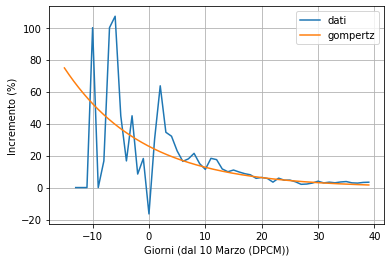

In [17]:
## Incremento percentuale
from scipy.signal import savgol_filter

ratio = (pv_casi / np.roll(pv_casi,1) - 1) * 100
ratio = ratio[1:]
plt.xlabel('Giorni (dal 10 Marzo (DPCM))')
plt.ylabel('Incremento (%)')
plt.grid()
plt.plot(t[1:], ratio, label='dati')
plt.plot(tt, 100*dgompertz(tt + t_lockdown, *gom_popt)/gompertz(tt + t_lockdown, *gom_popt), label='gompertz')
plt.legend()